In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow as pa

print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('seaborn version:', sns.__version__)
print('pyarrow version:', pa.__version__)


numpy version: 1.20.3
pandas version: 1.3.4
seaborn version: 0.11.2
pyarrow version: 8.0.0


# Data Importing

Loading both a single parquet file and all files into dataframes for examination.

In [2]:
import glob

# Local path to the dataset files: roadworks folder contains the parquets in this case
# localpath = '/Stuff/School/SOFT/FHICT-S4-AI/Group/ANWB/roadworks'
# isFirstRun = True
# filesRead = 0
# for path in glob.glob(f"{localpath}/*"):
    

# #   Setting the relative path: this notebook is in the same directory as the roadworks folder that contains the parquets 
#     path = path.replace(f"{localpath}\\", "roadworks/")
#     if (path == 'roadworks/_SUCCESS'):
#         continue
#     else:
#         filesRead += 1
#         print(f"files read: \033[1m {filesRead}\033[0m")
#         if (isFirstRun):
#             bdf = pd.read_parquet(path)
#             isFirstRun = False
#         else:
#             bdf = bdf.append(pd.read_parquet(path))

# sdf = pd.read_parquet("roadworks/part-00000-6d331a6a-a08a-4cfc-ad2c-d184f64be97e-c000.snappy.parquet")

pd.set_option('display.max_columns', None)

# Data Understanding

In [3]:
odf = bdf.copy()
odf.head()

NameError: name 'bdf' is not defined

In [ ]:
bdf.info()

In [ ]:
sdf.head()

## Feature Research

In [ ]:
bdf["roadwork_id"].is_unique

roadwork_id, while being an Id is not a unique value in this dataset. This is because the same roadworks have been set in the same dataset, this could be because information changed of the roadwork, or could be that the record was just collected multiple times.  
This will have to be explored and cleaned, afterwards roadwork_id should be able to be used as index.

In [ ]:
sdf["loaddatetimeutc"].unique()

loaddatetimeutc seems to perfectly cover 1 day of datapoints, this could mean that the loaddatetimeutc is the time that the data was taken from ANWB and set into the original parquet file.

In [ ]:
bdf['road'].unique()

Road shows the main road that the construction was done on. This feature should be categorial dtype.

In [ ]:
bdf['type'].unique()

Type seems to be in reference to road, where the type is what kind of road it is, in this case A or N which is also already conveyed in the road column.

In [ ]:
sdf[['roadwork_from', 'roadwork_to', 'roadwork_label', 'roadwork_reason', 'roadwork_start', 'roadwork_stop']].head()

roadwork_from/to contains locations, these locations however are not standardized using for example mileposts causing deviations.  
These features can for this reason not easily be used as good categorical data.

In [ ]:
bdf['roadwork_label'].unique()

roadwork label contains only closed (there are no missing values so there are no NAN's that could be considerd a different category), this feature is useless because it will not convey any new information on a per record basis.  

roadwork_reason is a text field that contains custom text.

roadwork_start/stop are datetimes, so these columns will have to be datetime dtypes (when reading this dataset using pandas, it automatically made these features datetimes, indicating that there are no incorrect date formats).

In [ ]:
bdf['radar_codedirection'].unique()

radar_codedirection contains 3 unique numbers, we assume that this is categorical however we do not know of what and will have to be looked into further.

In [ ]:
bdf[['roadwork_fromloc_lat', 'roadwork_fromloc_lon', 'roadwork_toloc_lat', 'roadwork_toloc_lon']]

roadwork_\*loc_\* holds the longtitude and latitude of the start and endlocation of the roadworks. 

In [ ]:
bdf[['roadwork_segmentid', 'segmentstart', 'segmentend']]

the segment columns indicate again the main start and endpoints of the roadworks, with the segmentid being an identifier for this segment.

In [ ]:
# bdf[['roadwork_afrc', 'roadwork_category', 'roadwork_type']]
bdf['roadwork_afrc'].unique()

roadwork_afrc contains 3 numerical values, these seem to be categorical but we do not know what it is refering.

In [ ]:
bdf['roadwork_category'].unique()

roadworks_category only contains the string 'roadworks' this gives no further information and can be ignored.

In [ ]:
bdf['roadwork_type'].unique()

roadwork_type contains two categorical values: a and n, these could reffer to the two types of main roads: A and N, however this has already been specified and would thus be unnecessary.

## Data Analysis

In [ ]:
bdf.describe()

The numerical values described above, seem to all not actually be numerical values that can be used as such. For example the roadwork_loc columns contain latitude and longtitude values that are linked to a location within the Netherlands, specifically roadpoints.

In [ ]:
changedRowsCols = bdf.columns[2:6].tolist() + bdf.columns[7:,].tolist()
# Get random indexer to test the check on
changedRowsIndex = bdf.sample(random_state=0)['roadwork_id'].values[0]
#                             ^Remove random_state to get a truely new random sample
changedRowsMask = bdf[bdf['roadwork_id'] == changedRowsIndex][changedRowsCols].shift() != bdf[bdf['roadwork_id'] == changedRowsIndex][changedRowsCols]

def CheckMask(col):
    print(f"Column {col.name} has changing values: \033[1m {True in col}\033[0m")
    
changedRowsMask.loc[changedRowsMask.index[1:,]].apply(func=CheckMask);
#               ^Skip first entry because this will always be marked as true


*Note: This test has a bug where it will sometimes also read an empty row, causing the changed status to become True for all columns*  
From the check above it can be seen that when randomly sampling a roadwork_id, and checking all records referencing this Id, the values stay the same. This proves our original theory that the identical roadwork_id's are caused by the gathering method of JUGO who fetch the same record multiple times.
(roadwork_reason does change sometimes however, but this can be dealt with by sorting on loaddatetimeutc and using the newest roadwork_reason)

This means that the identical records can be removed/merged into one record for the given roadwork_id

In [ ]:
df = bdf.sort_values('loaddatetimeutc').drop_duplicates(subset='roadwork_id', keep='last')
print(f"Is roadwork_id unique: \033[1m {df['roadwork_id'].is_unique}\033[0m")

In [ ]:
df.info()

The indexing has gone wrong while reading all the parquet files. Which probably caused the indexing to be wrong.

In [ ]:
df.loc[100,:].head(5)
# findings that there are duplicate index rows

Resetting the index to fix the duplicates and order

In [ ]:
df=df.reset_index(drop=True)

In [ ]:
df.info()

Checking for null values

In [ ]:
df.isnull().sum()

There were really few rows with null values, if we dont count the roadwork_label missing values. But it doesn't matter, since the data is just an explanation of the roadworks. We don't need to know what is being worked on, we just need to know the road and duration it's being worked on


Checking if the A or N roads have more roadworks

In [ ]:
sns.histplot(df['type'])

Plotting the data in a histogram to get a better view of how much roadworks each road has.

In [ ]:
plt.figure(figsize = (15,50))
hisroads = sns.histplot(y=df['road'].sort_values(ascending=True), color='g', shrink=.69, binwidth =50)
plt.axvline(10, color='red')

Some road's don't have enough data, so we can't train the model. This causes us to not be able to predict the future using Time Series Prediction.

In [ ]:
df=bdf.copy()
df.info()

As you can see in the histogram below. There's very little data before 2020

In [ ]:
plt.figure(figsize = (10,6))
s = sns.histplot(df['roadwork_start']
                 #.dt.strftime("%b")
                )


The months September and October are the months with the most roadworks

In [ ]:
plt.figure(figsize = (15,5))
s = sns.histplot(df['roadwork_start'].dt.month, bins=np.arange(1, 13 +1), kde=True)
s.set(xticks=[1,2,3,4,5,6,7,8,9,10,11,12]);
# ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

# Data preparation

In [ ]:
df.tail(3)

We're removing the last row since it's null for some reason

In [ ]:
df = df.loc[:7037]

In [ ]:
df.to_csv('mergedroadworks.csv')

In [ ]:
df = pd.read_csv('mergedroadworks.csv', parse_dates=['loaddatetimeutc', 'roadwork_start', 'roadwork_stop'])

Saving the merged parquets to CSV for future use since it'll be less of a headache to run the whole notebook.

In [ ]:
df[df['segmentend'].isnull()]

We've concluded that this row was probably kept empty, since they were working on a roundabout. This is the best assumption to make since every other row is filled and this is the only point that is near a roundabout.

In [ ]:
df.loc[2917,['roadwork_toloc_lat', 'roadwork_toloc_lon', 'segmentstart', 'segmentend']] = [df.loc[2917]['roadwork_fromloc_lat'], df.loc[2917]['roadwork_fromloc_lon'], 'Dronten', 'Dronten']

As stated above the missing value is for a roundabout. Which means we can just fill in the same longitude and latitude in the segmentstart and end. Other than that we've filled in the placename with the corresponding lat and lon information we've being given.

In [ ]:
df.loc[2917]

Making sure that we've updated the information correctly in the 2917th row.

In [ ]:
# Get list of dates for index min -> max of df 
firstDate = df['loaddatetimeutc'].min()
lastDate = df['loaddatetimeutc'].max()
days = pd.date_range(firstDate, lastDate, freq='D')

tdf = pd.DataFrame({'date': days.date, 'roadworks':0})
tdf['date'] = tdf['date'].astype('datetime64')
tdf = tdf.set_index('date', drop=False)

tdf['weekday'] = tdf['date'].dt.weekday

tdf

Making a new dataframe based on timeseries, to more easily allow for timeseries predictions to be handled.

In [ ]:
def MergeTDF(row):
    tdf.loc[f"{row.loaddatetimeutc.date()}",'roadworks'] = tdf.loc[f"{row.loaddatetimeutc.date()}",'roadworks'] + 1
#           ^Convert Timestamp to string because it doesn't like comparing two different date types
    
df.apply(axis=1, func=MergeTDF)
print('Done')
tdf

Filling new dataframe based on previous roadworks data.

In [ ]:
tdf[['roadworks', 'weekday']].to_csv('timeseriesroadworks.csv')

After restructuring the data into the new csv, it is also significantly easier to visualize data. We have done this below to give us a better idea of our data density

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15,10))
lp = sns.lineplot(x='date', y='roadworks', data=tdf[tdf.index.year == 2020], ax=ax[0]).set(title='2020')
lp = sns.lineplot(x='date', y='roadworks', data=tdf[tdf.index.year == 2021], ax=ax[1]).set(title='2021')
lp = sns.lineplot(x='date', y='roadworks', data=tdf[tdf.index.year == 2022], ax=ax[2]).set(title='2022')

for plot in ax:
    plot.tick_params(labelrotation=45)
    plot.set_ylim([-2, 65])

As seen only 2021 is a full year of, with 2020 giving us a later period of the year and 2022 only the start. It is also visible that during 2021 there were some periods with either no roadworks, or no new roadworks reported in our dataset.

# Pre Processing

In this section we're going to be using Time Series Forecasting. Time Series Forecasting is a method where you make predictions based on historical information. 

## Feature Selection


The features we're selecting in this case are the roadworks over the whole Netherlands. The reason we've chosen this is because we want to get a general conclusion this iteration. If we see the ability in going more in depth for this section, we'll be doing this in future iterations. Another reason we're not doing it per road is because not every road has enough datasets.

## Model Selection


The ARIMA model forecasts a time series using its own previous values. It can be used to any nonseasonal sequence of numbers that shows patterns rather than being a series of random events. Sales data from a clothes store, for example, would be a time series because it was collected over time. One of the most distinguishing features is that the data is collected at regular intervals. 

We're going to be using the SARIMA model which is a variation on the ARIMA model. In the SARIMA model we're also taking in account the seasonal aspect.

The SARIMA model contains pdq (placeholders for AR-I-MA in the same order as p-d-q) and PDQ. The lower case pdq variables are used for the normal forecast. But the capital letter PDQ are used for seasonal predications. Last but not least we've the S variable, which is for the period of the time series. Basically in which timeframe it's repeating itself. We'll go more in depth about the pdq variables in the text below:

    -S: How long it takes for the data to repeat (yearly in our case)
    
    -p: Trend autoregression order. The amount of data it takes from historical data, to predict the future.
    -d: Trend difference order. How often the difference of value gets used in the data. Δt
    -q: Trend moving average order. The difference there is in historical data points.
     
The above information is the same for the PDQ but instead of trend it's seasonal. The higher the value in pdq the more terms they use in the model.

We will be doing step-ahead forecasting and dynamic forecasting. This allows for either a more accurate model to be used, that will have to be trained every time new data comes in, or a model to be used that will become less accurate over time and will have to be trained with new data after a certain threshold.

## Pre Modelling
Below we have done some visualizing of the data as to give us an idea of how the model might perform during the modelling phase.

In [4]:
tdf = pd.read_csv('timeseriesroadworks.csv', dtype={'roadwork': 'int64','weekday': 'int64'}, parse_dates=['date'])
tdf = tdf.set_index('date', drop=False)

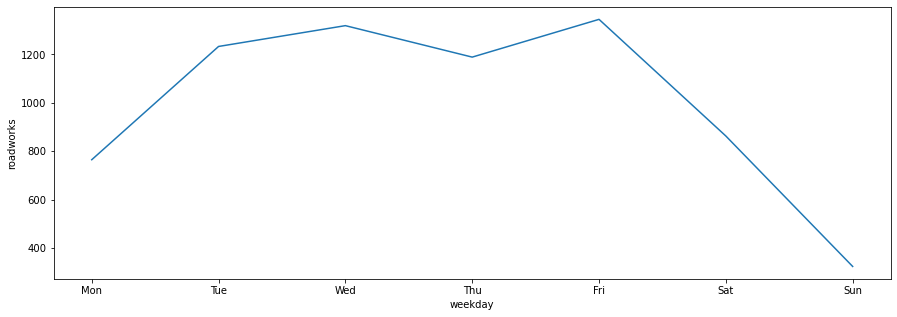

In [5]:
wddf = pd.DataFrame({'weekday': np.arange(7), 'roadworks':0})
def GenerateWeekDayDF(row):
    wddf.loc[row.weekday,'roadworks'] = wddf.loc[row.weekday,'roadworks'] + row.roadworks
    
tdf.apply(axis=1, func=GenerateWeekDayDF)

plt.figure(figsize = (15,5))
lp = sns.lineplot(x=wddf['weekday'], y=wddf['roadworks'])
lp.set(xticks=[0,1,2,3,4,5,6]);
lp.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun']);

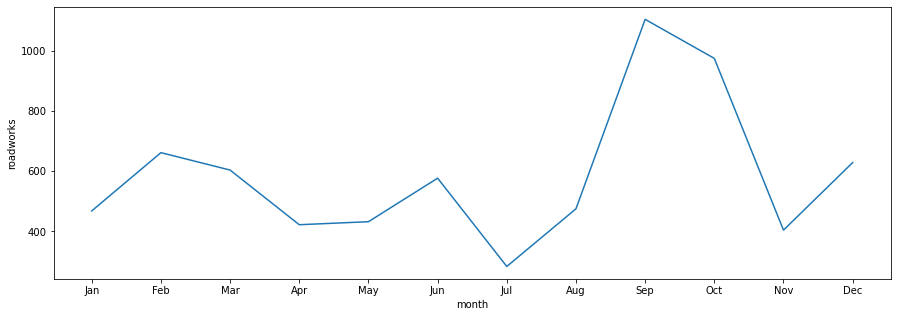

In [6]:
mdf = pd.DataFrame({'month': np.arange(1, 13), 'roadworks':0})
def GenerateMonthDF(row):
    mdf.loc[row.date.month - 1,'roadworks'] = mdf.loc[row.date.month - 1,'roadworks'] + row.roadworks
    
tdf.apply(axis=1, func=GenerateMonthDF)

plt.figure(figsize = (15,5))
lp = sns.lineplot(x=mdf['month'], y=mdf['roadworks'])
lp.set(xticks=[1,2,3,4,5,6,7,8,9,10,11,12])
lp.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']);

When looking at the data by weekday or month, there is a clearly visible fluctuation line, with Monday, Saturday and Sunday being low roadwork days, and late summer/fall is a high roadworks period based yearly.  
This shows that the roadworks do seem to be in a pattern allowing for a timeseries predictor to have a better time prediction roadworks in the future.

# Modelling

As stated during the [Model Selection](#Model-Selection), we will be using SAMIRA to forecast our timeseries, for this we will be trying out step-ahead and dynamic forcasting.  
Our first attempt will be going through all different hyper paramaters to find the most optimal one, increasing the range of the paramaters however will greatly increase the process time because of the amount of paramaters there are to tune.

In [14]:
import statsmodels
import statsmodels.api as sm
import itertools
import warnings

# Function for fitting model and returning the results object
def FitModel(param, seasonalParam):
    saim = sm.tsa.statespace.SARIMAX(tdf[['roadworks']],
                                order=param,
                                seasonal_order=seasonalParam,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    return saim.fit()

In [15]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonalPdq = [(x[0], x[1], x[2], 12) for x in pdq]

results = dict()
# Run through every pdq variant
for param in pdq:
#     Run through every seaonsal PDQ variant aswell
    for seasonalParam in seasonalPdq:
        try:
#             Store the results in dict
            results[f"{param}-{seasonalParam}"] = FitModel(param, seasonalParam)
        except:
            continue

In [16]:
# Set AIC results in dataframe for easy readability
resultsdf = pd.DataFrame(columns=['params', 'AIC'])
for name, result in results.items():
    resultsdf = resultsdf.append({'params': name, 'AIC': result.aic}, ignore_index=True)

resultsdf.sort_values('AIC', ascending=True).head(5)

,params,AIC


AIC is a measurement used to identify the best model relative to other models of the same type, AIC shows the goodness of fit for a model and will also penalize a model based on it's complexity to discourage overfitting, this means that a lower AIC score would be considered better relative to other models. 
From our testing we found that pdq = 1, PDQ = 1 and S=12 performed most favorably when looking at the AIC score

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2967      0.041      7.218      0.000       0.216       0.377
ma.L1         -0.8839      0.027    -32.763      0.000      -0.937      -0.831
ar.S.L12      -0.0530      0.045     -1.177      0.239      -0.141       0.035
ma.S.L12      -1.0000    105.463     -0.009      0.992    -207.704     205.704
sigma2        84.7121   8935.656      0.009      0.992   -1.74e+04    1.76e+04


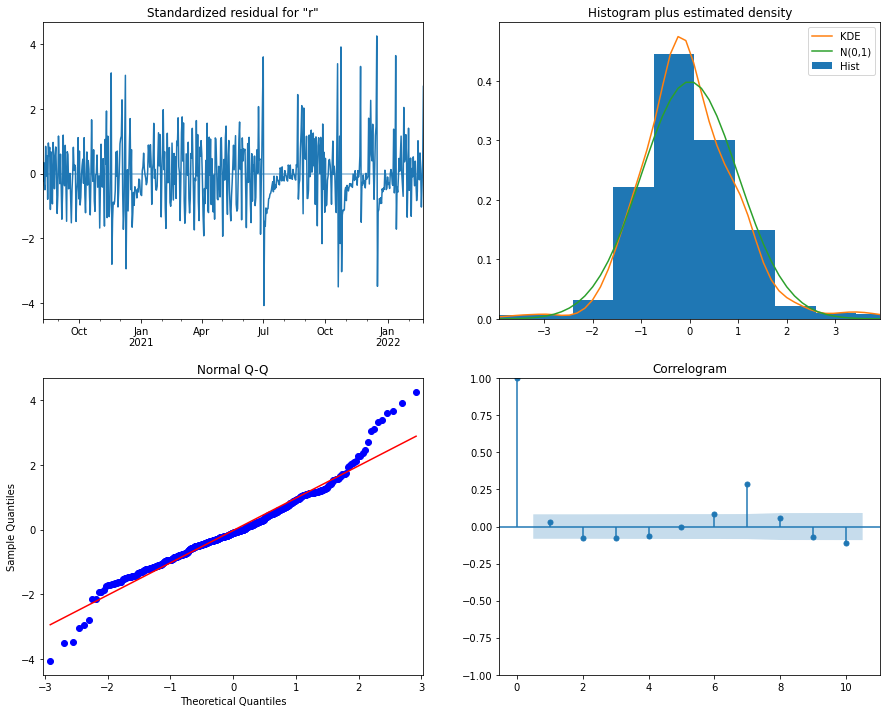

In [10]:
print(results['(1, 1, 1)-(1, 1, 1, 12)'].summary().tables[1])
results['(1, 1, 1)-(1, 1, 1, 12)'].plot_diagnostics(figsize=(15, 12))
plt.show()

In [11]:
tdf[['roadworks']].describe()

,roadworks
count,591.000000
mean,11.908629
std,10.957628
min,0.000000
25%,1.000000
50%,11.000000
75%,19.000000
max,64.000000


When looking at the 'best' model we can see that the residual (how wrong the model was when predicting roadworks) is never more than 4, when looking at the average roadworks per day (being 11.9) does not seem too bad and can still give a good indication of how much roadwork is done on a day.
Furthermore, when comparing the residual with a normal distribution, it is shown that it quiet nicely follows the normal distrubtion line, while having a steeper peak meaning that most of our residuals reside closer to 0 indicating that when our model is wrong it more often than not is only slightly wrong.
Lastly in the Normal Q-Q graph, it is seen that most data nicely follows the normal distribution line, only deviating near the extremes. Possibly because there are less of the extreme values in our dataset.

In [12]:
model = results['(1, 1, 1)-(1, 1, 1, 12)']

In [13]:
pred = model.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()

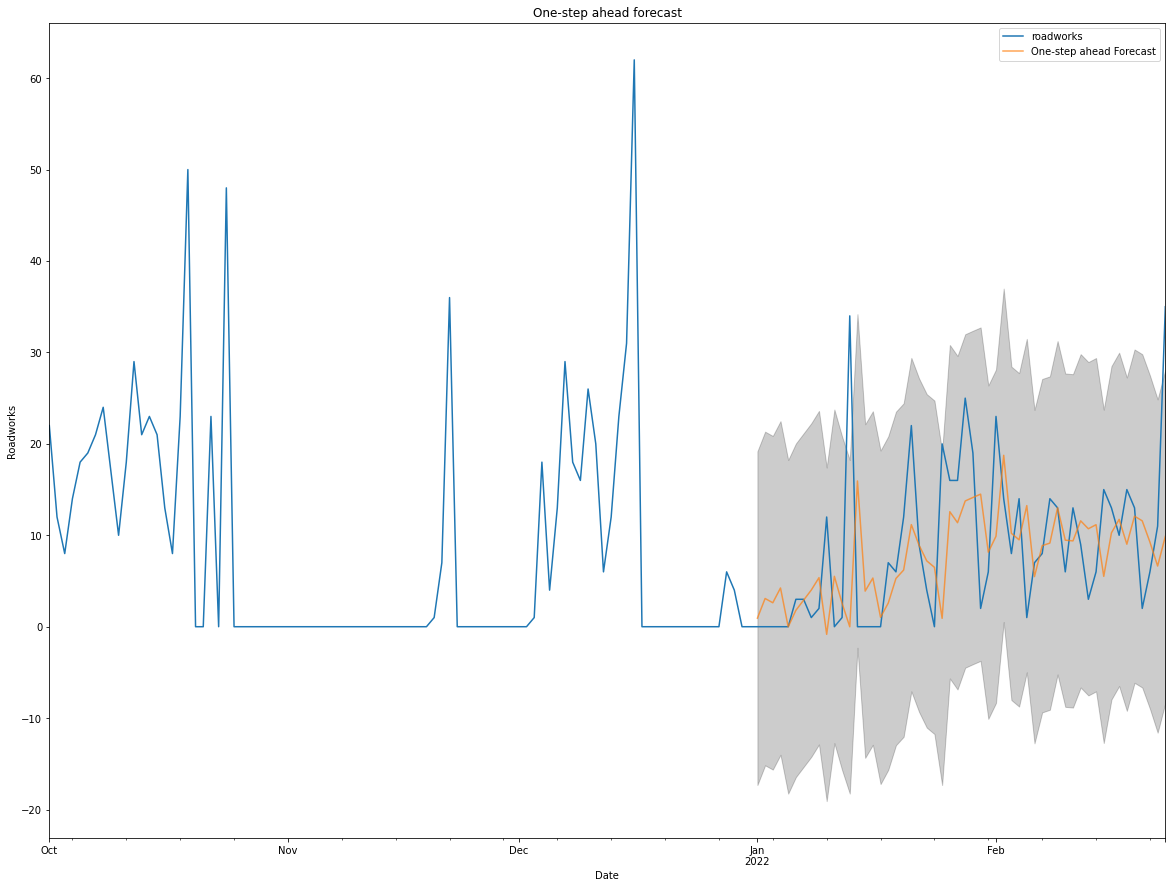

In [14]:
# Show reference data
ax = tdf[['roadworks']]['2021-10':].plot(label='observed', figsize=(20, 15))
# Show predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
# Show confidence of the model's prediction
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Roadworks')
ax.set_title('One-step ahead forecast')
plt.legend()

plt.show()

When using one-step ahead forecasting, it is seen that the model performs pretty poorly, it is not very certain of it's prediction because of the very sparatic changes and is always lagging behind the real world data sometimes predicting low roadworks when there is actually a spike.

In [15]:
pred_date = '2022-01-01'
pred_dynamic = model.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

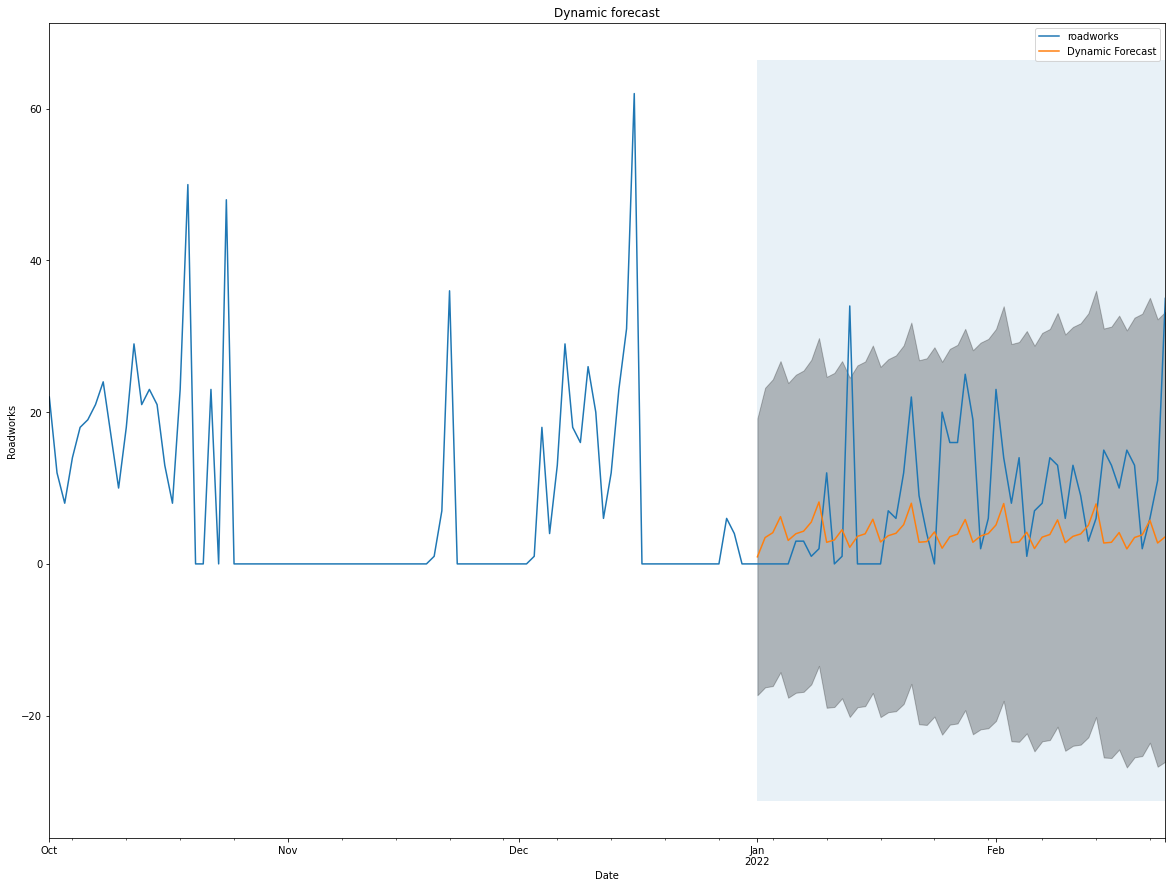

In [16]:
# Show reference data
ax = tdf[['roadworks']]['2021-10':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
# Show predicted values
ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
# Show confidence of the model's prediction
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(pred_date), tdf[['roadworks']].index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Roadworks')
ax.set_title('Dynamic forecast')

plt.legend()
plt.show()

It seems that the dynamic forcast, does not have that much data to go off of, causing the pattern to be clearly visible and the model to still not be very sure of it's prediction. However it is important to mention that while the model clearly under shoots it's predictions, the pattern it uses does allign pretty well.

# Evaluation

Before we went into this section we expected the model to be fairly accurate. But after creating the model and letting it run the prediction, we've seen that the predication is not very confident. The model has a low confidence because of the rapid changes and sparatic data in the dataset.  

As for the one-step ahead forecast, it is visible that the predictor is mostly behind on it's predictions and because of this is wrong a lot, because it tries to compensate for a previous spike while the data has already changed significantly.
While the dynamic forcast did not perform much better, it is visible that the pattern it discovered to use for the forecast, does fit the data fairly well while however generally underpredicting.

This shows that the data does follow somewhat of a predictable pattern that could be used to give atleast an indication of the future roadworks.

We also think that covid-19 could have a large affect on this. The data used is very much of a time where less people are driving, with 2022 being around the time where everyone went back on the road, this can throw off the predictions significantly and it could be worth looking into older data to see if this is true.

# Applying JUGO's feedback 

The feedback that we've gotten for this notebook is that we should've removed the times and days that don't fit the working hours of employees. We also got some feedback that we might look into some outliers and remove them.

So we've decided to remove saturdays and sundays as those are irrelevant as working days. Other than that we're narrowing down the scope to 06:00 - 19:00. Most fulltime workers start working around 09:00 and finish their job around 17:000. We've decided to take 06:00 as the start time, since some workers have to travel 1-2 hours to their job, or want to be early and evade the traffic jams. Also the client could decide to get to work later and leave later, so we've agreed to keep 19:00 still in the dataframe.

In [3]:
df = pd.read_csv('mergedroadworks.csv', parse_dates=['loaddatetimeutc', 'roadwork_start', 'roadwork_stop'])

Reimporting the csv manually here since it's easier to work this way. We don't have to go back up all the way to the cells above while continuing our notebook work.

In [4]:
df.head(5)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,roadwork_id,loaddatetimeutc,road,type,roadwork_from,roadwork_to,roadwork_label,...,roadwork_fromloc_lat,roadwork_fromloc_lon,roadwork_toloc_lat,roadwork_toloc_lon,roadwork_segmentid,segmentstart,segmentend,roadwork_afrc,roadwork_category,roadwork_type
0,0,0,0,245069631.0,2020-07-13 16:48:00,A15,a,de Botlektunnel,de Botlektunnel,NaN,...,51.87055,4.33089,51.87055,4.33089,3059.0,Rotterdam,Europoort,0.0,roadworks,a
1,1,1,1,244997097.0,2020-07-13 16:59:00,N7,n,Groningen-Helpman,Groningen-Helpman,closed,...,53.20534,6.57403,53.20534,6.57403,3412.0,Groningen,Duitse grens,3.0,roadworks,n
2,2,2,2,245068994.0,2020-07-13 18:28:00,A10,a,afrit Haarlem,Amsterdam-Slotermeer,closed,...,52.38177,4.84478,52.37517,4.84282,3014.0,knp. Coenplein,knp. De Nieuwe Meer,0.0,roadworks,a
3,3,3,3,245068546.0,2020-07-13 18:28:00,A7,a,Sappemeer,Foxhol,closed,...,53.16719,6.80953,53.17849,6.73195,3404.0,Duitse grens,Groningen,0.0,roadworks,a
4,4,4,4,244997614.0,2020-07-13 22:59:00,N31,n,Leeuwarden,Leeuwarden,closed,...,53.18943,5.74664,53.18943,5.74664,3232.0,Drachten,Leeuwarden,3.0,roadworks,n


Making sure the data is correct that we've imported

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7038 entries, 0 to 7037
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            7038 non-null   int64         
 1   Unnamed: 0.1          7038 non-null   int64         
 2   Unnamed: 0.1.1        7038 non-null   int64         
 3   roadwork_id           7038 non-null   float64       
 4   loaddatetimeutc       7038 non-null   datetime64[ns]
 5   road                  7038 non-null   object        
 6   type                  7038 non-null   object        
 7   roadwork_from         7038 non-null   object        
 8   roadwork_to           7038 non-null   object        
 9   roadwork_label        6729 non-null   object        
 10  roadwork_reason       7038 non-null   object        
 11  roadwork_start        7038 non-null   datetime64[ns]
 12  roadwork_stop         7038 non-null   datetime64[ns]
 13  radar_codedirectio

Using the info function so that we can use this table for future use. Also to make sure that we don't have any null values in roadworks_start

In [6]:
df = df.set_index('roadwork_start', drop=False)

Setting the roadwork_start as index, so that we can filter on it in the next cell

In [7]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,roadwork_id,loaddatetimeutc,road,type,roadwork_from,roadwork_to,roadwork_label,...,roadwork_fromloc_lat,roadwork_fromloc_lon,roadwork_toloc_lat,roadwork_toloc_lon,roadwork_segmentid,segmentstart,segmentend,roadwork_afrc,roadwork_category,roadwork_type
roadwork_start,,,,,,,,,,,,,,,,,,,,,
2020-07-14 20:00:00,0,0,0,245069631.0,2020-07-13 16:48:00,A15,a,de Botlektunnel,de Botlektunnel,NaN,...,51.87055,4.33089,51.87055,4.33089,3059.0,Rotterdam,Europoort,0.0,roadworks,a
2020-07-13 04:00:00,1,1,1,244997097.0,2020-07-13 16:59:00,N7,n,Groningen-Helpman,Groningen-Helpman,closed,...,53.20534,6.57403,53.20534,6.57403,3412.0,Groningen,Duitse grens,3.0,roadworks,n
2020-07-14 19:00:00,2,2,2,245068994.0,2020-07-13 18:28:00,A10,a,afrit Haarlem,Amsterdam-Slotermeer,closed,...,52.38177,4.84478,52.37517,4.84282,3014.0,knp. Coenplein,knp. De Nieuwe Meer,0.0,roadworks,a
2020-07-14 18:00:00,3,3,3,245068546.0,2020-07-13 18:28:00,A7,a,Sappemeer,Foxhol,closed,...,53.16719,6.80953,53.17849,6.73195,3404.0,Duitse grens,Groningen,0.0,roadworks,a
2020-07-13 19:00:00,4,4,4,244997614.0,2020-07-13 22:59:00,N31,n,Leeuwarden,Leeuwarden,closed,...,53.18943,5.74664,53.18943,5.74664,3232.0,Drachten,Leeuwarden,3.0,roadworks,n


Making sure the index is properly set to roadwork_start.

In [8]:
df.between_time('06:00','19:00')

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,roadwork_id,loaddatetimeutc,road,type,roadwork_from,roadwork_to,roadwork_label,...,roadwork_fromloc_lat,roadwork_fromloc_lon,roadwork_toloc_lat,roadwork_toloc_lon,roadwork_segmentid,segmentstart,segmentend,roadwork_afrc,roadwork_category,roadwork_type
roadwork_start,,,,,,,,,,,,,,,,,,,,,
2020-07-14 19:00:00,2,2,2,245068994.0,2020-07-13 18:28:00,A10,a,afrit Haarlem,Amsterdam-Slotermeer,closed,...,52.38177,4.84478,52.37517,4.84282,3014.0,knp. Coenplein,knp. De Nieuwe Meer,0.0,roadworks,a
2020-07-14 18:00:00,3,3,3,245068546.0,2020-07-13 18:28:00,A7,a,Sappemeer,Foxhol,closed,...,53.16719,6.80953,53.17849,6.73195,3404.0,Duitse grens,Groningen,0.0,roadworks,a
2020-07-13 19:00:00,4,4,4,244997614.0,2020-07-13 22:59:00,N31,n,Leeuwarden,Leeuwarden,closed,...,53.18943,5.74664,53.18943,5.74664,3232.0,Drachten,Leeuwarden,3.0,roadworks,n
2020-07-13 18:00:00,5,5,5,245070817.0,2020-07-13 23:58:00,N48,n,Dedemsvaart,Dedemsvaart,closed,...,52.60263,6.40750,52.60263,6.40750,5390.0,Hoogeveen,Ommen,3.0,roadworks,n
2020-07-13 19:00:00,8,8,16,242443878.0,2020-07-14 02:58:00,A29,a,knp. Sabina,Willemstad,closed,...,51.65990,4.41906,51.68114,4.41830,3210.0,Bergen op Zoom,Rotterdam,0.0,roadworks,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24 19:00:00,7025,7025,7019,305481241.0,2022-02-23 18:00:00,A12,a,De Meern,De Meern,closed,...,52.07311,5.02858,52.07311,5.02858,3020.0,Utrecht,Den Haag,0.0,roadworks,a
2022-02-24 19:00:00,7027,7027,7017,305477931.0,2022-02-23 18:00:00,A2,a,Nieuwegein-Zuid,Nieuwegein-Zuid,closed,...,52.00381,5.07480,52.00381,5.07480,3104.0,'s-Hertogenbosch,Utrecht,0.0,roadworks,a
2022-02-12 12:30:00,7030,7030,7014,304242728.0,2022-02-23 18:00:00,A1,a,Hoevelaken,Hoevelaken,closed,...,52.17043,5.43905,52.17043,5.43905,3000.0,Amersfoort,Amsterdam,0.0,roadworks,a


As you can see there are 3438 rows and in the dataset there were 7038 rows, when we checked with info function.

Which means we were examing more than double the data as before while using SARIMA. Hopefully the SARIMA function will give us a better prediction.

In [9]:
# Get list of dates for index min -> max of df 
firstDate = df['roadwork_start'].min()
lastDate = df['roadwork_start'].max()
days = pd.date_range(firstDate, lastDate, freq='D')

udf = pd.DataFrame({'date': days.date, 'roadworks':0})
udf['date'] = udf['date'].astype('datetime64')
udf = udf.set_index('date', drop=False)

udf['weekday'] = udf['date'].dt.weekday

udf

,date,roadworks,weekday
date,,,
2019-03-22,2019-03-22,0,4
2019-03-23,2019-03-23,0,5
2019-03-24,2019-03-24,0,6
2019-03-25,2019-03-25,0,0
2019-03-26,2019-03-26,0,1
...,...,...,...
2022-02-28,2022-02-28,0,0
2022-03-01,2022-03-01,0,1
2022-03-02,2022-03-02,0,2


In [10]:
def MergeUDF(row):
    udf.loc[f"{row.roadwork_start.date()}",'roadworks'] = udf.loc[f"{row.roadwork_start.date()}",'roadworks'] + 1
#           ^Convert Timestamp to string because it doesn't like comparing two different date types
    
df.apply(axis=1, func=MergeUDF)
print('Done')
udf

Done


,date,roadworks,weekday
date,,,
2019-03-22,2019-03-22,2,4
2019-03-23,2019-03-23,0,5
2019-03-24,2019-03-24,0,6
2019-03-25,2019-03-25,0,0
2019-03-26,2019-03-26,0,1
...,...,...,...
2022-02-28,2022-02-28,0,0
2022-03-01,2022-03-01,0,1
2022-03-02,2022-03-02,0,2


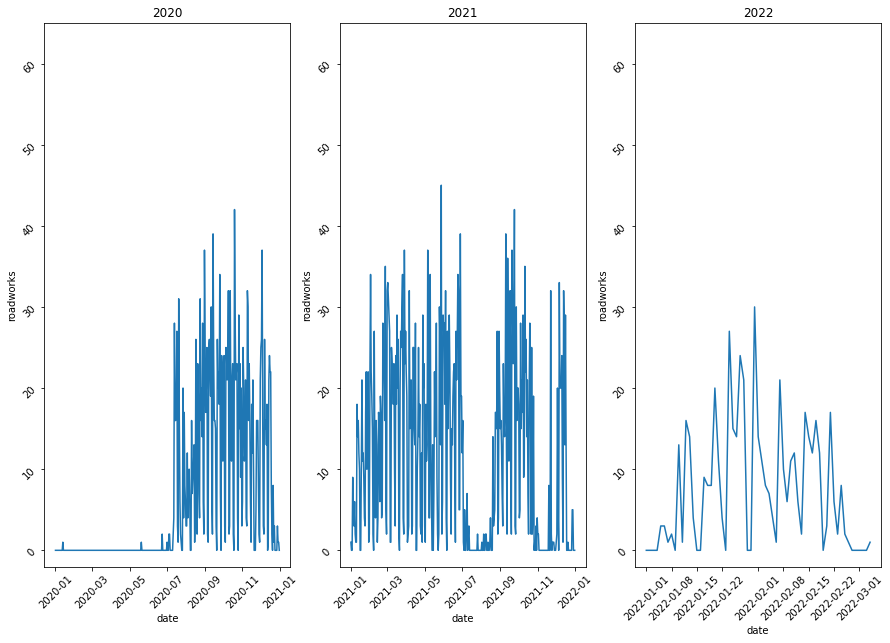

In [11]:
fig, ax = plt.subplots(1,3,figsize=(15,10))
lp = sns.lineplot(x='date', y='roadworks', data=udf[udf.index.year == 2020], ax=ax[0]).set(title='2020')
lp = sns.lineplot(x='date', y='roadworks', data=udf[udf.index.year == 2021], ax=ax[1]).set(title='2021')
lp = sns.lineplot(x='date', y='roadworks', data=udf[udf.index.year == 2022], ax=ax[2]).set(title='2022')

for plot in ax:
    plot.tick_params(labelrotation=45)
    plot.set_ylim([-2, 65])

As you can see, we immediately have way less spikes and way less 0 roadwork days. Other than that a lot of the first few months are gone. We've also used roadwork_start instead of loaddatetime_utc, which caused some null days to be filled. This caused our data to be skewed, which caused inconsistencies in the future prediction. Other than that we had a lot of null values while the servers were down, which were untrue. The roadwork_start dates were saved afterwards, which we didn't use in the previous future prediction

We're also going to be removing the data before 07-2020, since there's too little information available here. We consider this as outliers.

OLD graph:
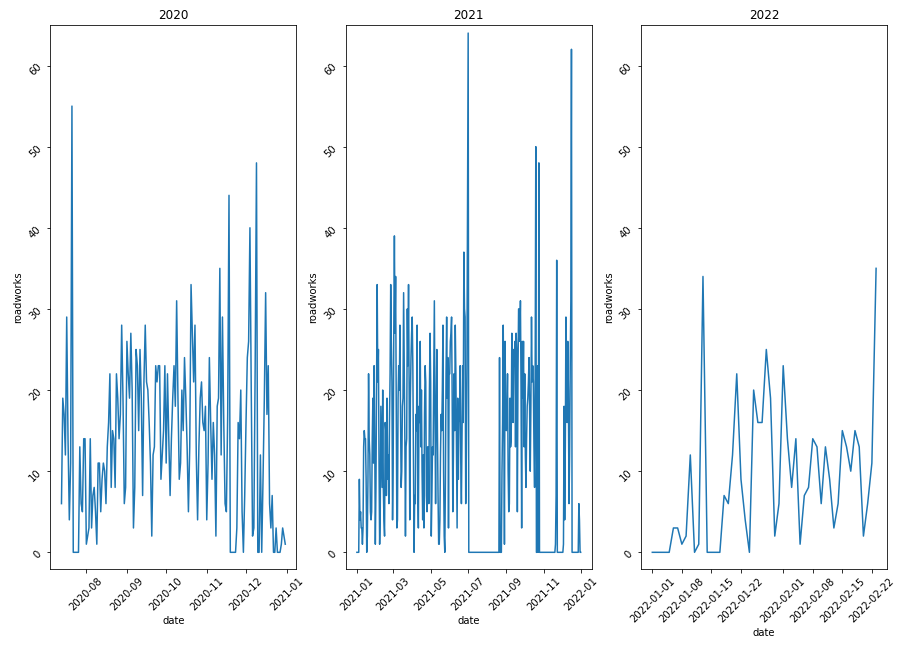

In [25]:
udf = udf.loc['2020-07':,]

Removing the data before 2020-07

In [28]:
# Function for fitting model and returning the results object
def FitModel(param, seasonalParam):
    usaim = sm.tsa.statespace.SARIMAX(udf[['roadworks']],
                                order=param,
                                seasonal_order=seasonalParam,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    return usaim.fit()

In [29]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonalPdq = [(x[0], x[1], x[2], 12) for x in pdq]

results = dict()
# Run through every pdq variant
for param in pdq:
#     Run through every seaonsal PDQ variant aswell
    for seasonalParam in seasonalPdq:
        try:
#             Store the results in dict
            results[f"{param}-{seasonalParam}"] = FitModel(param, seasonalParam)
        except:
            continue

In [30]:
# Set AIC results in dataframe for easy readability
resultsudf = pd.DataFrame(columns=['params', 'AIC'])
for name, result in results.items():
    resultsudf = resultsudf.append({'params': name, 'AIC': result.aic}, ignore_index=True)

resultsudf.sort_values('AIC', ascending=True).head(5)

,params,AIC
63,"(1, 1, 1)-(1, 1, 1, 12)",4354.327349
31,"(0, 1, 1)-(1, 1, 1, 12)",4360.914541
47,"(1, 0, 1)-(1, 1, 1, 12)",4364.542449
59,"(1, 1, 1)-(0, 1, 1, 12)",4382.103045
57,"(1, 1, 1)-(0, 0, 1, 12)",4387.719876


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1389      0.048      2.897      0.004       0.045       0.233
ma.L1         -0.8529      0.030    -28.858      0.000      -0.911      -0.795
ar.S.L12      -0.2658      0.042     -6.296      0.000      -0.349      -0.183
ma.S.L12      -1.0000    218.005     -0.005      0.996    -428.282     426.282
sigma2        90.8710   1.98e+04      0.005      0.996   -3.87e+04    3.89e+04


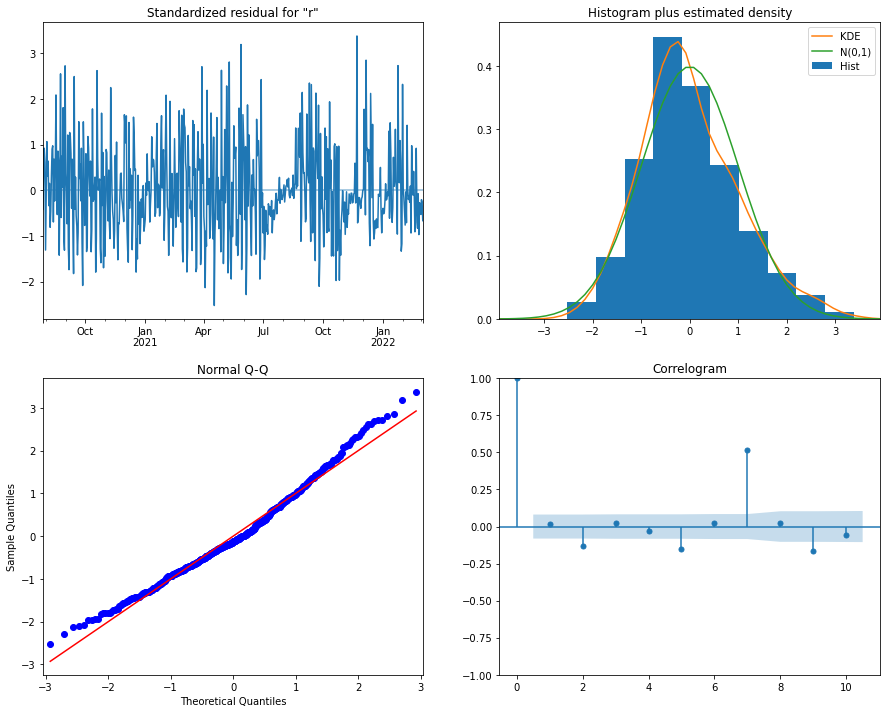

In [31]:
print(results['(1, 1, 1)-(1, 1, 1, 12)'].summary().tables[1])
results['(1, 1, 1)-(1, 1, 1, 12)'].plot_diagnostics(figsize=(15, 12))
plt.show()

In [32]:
model = results['(1, 1, 1)-(1, 1, 1, 12)']

In [33]:
pred = model.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()

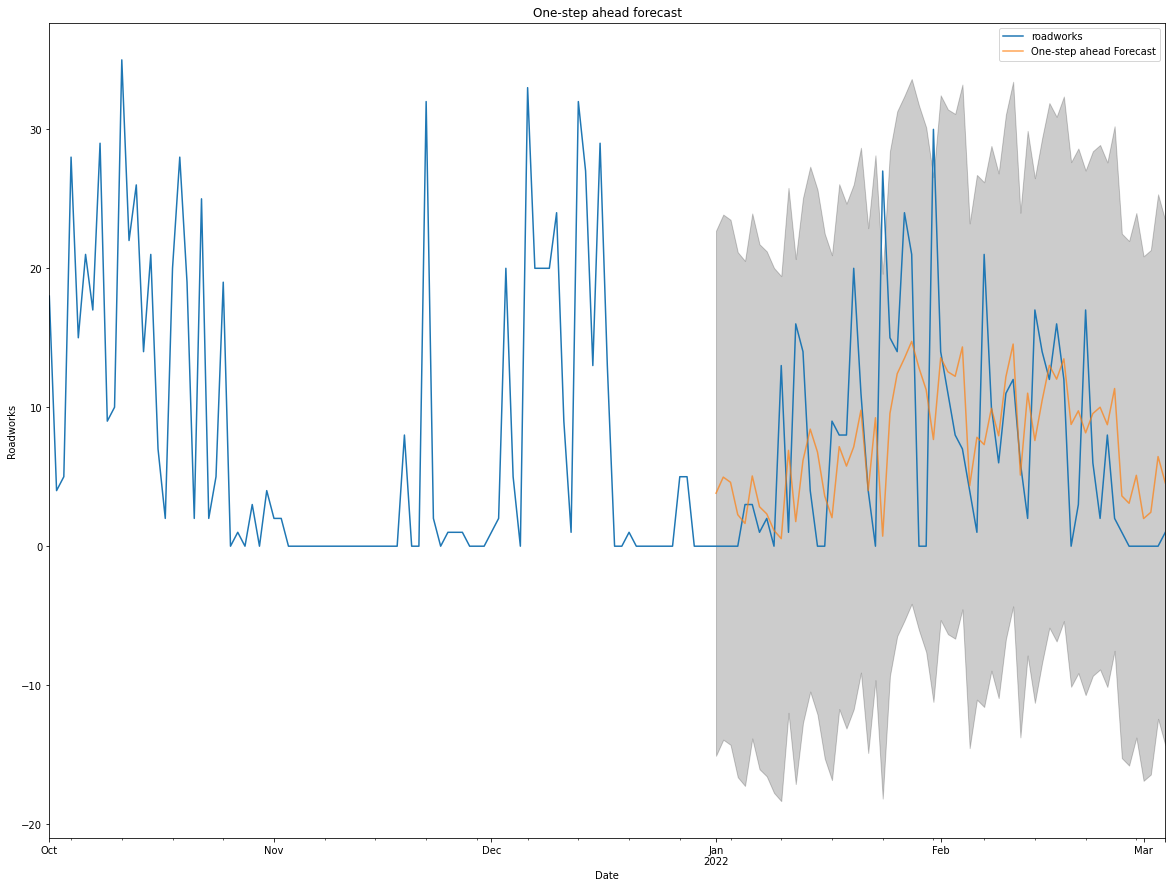

In [34]:
# Show reference data
ax = udf[['roadworks']]['2021-10':].plot(label='observed', figsize=(20, 15))
# Show predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
# Show confidence of the model's prediction
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Roadworks')
ax.set_title('One-step ahead forecast')
plt.legend()

plt.show()

OLD GRAPH:

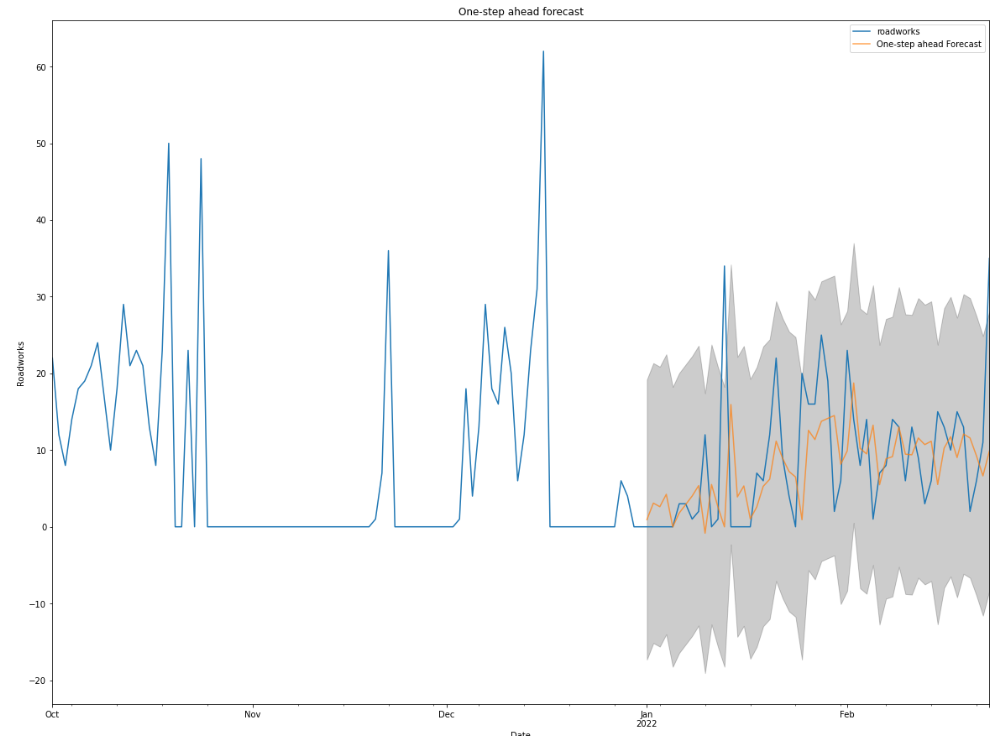

In [35]:
pred_date = '2022-01-01'
pred_dynamic = model.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

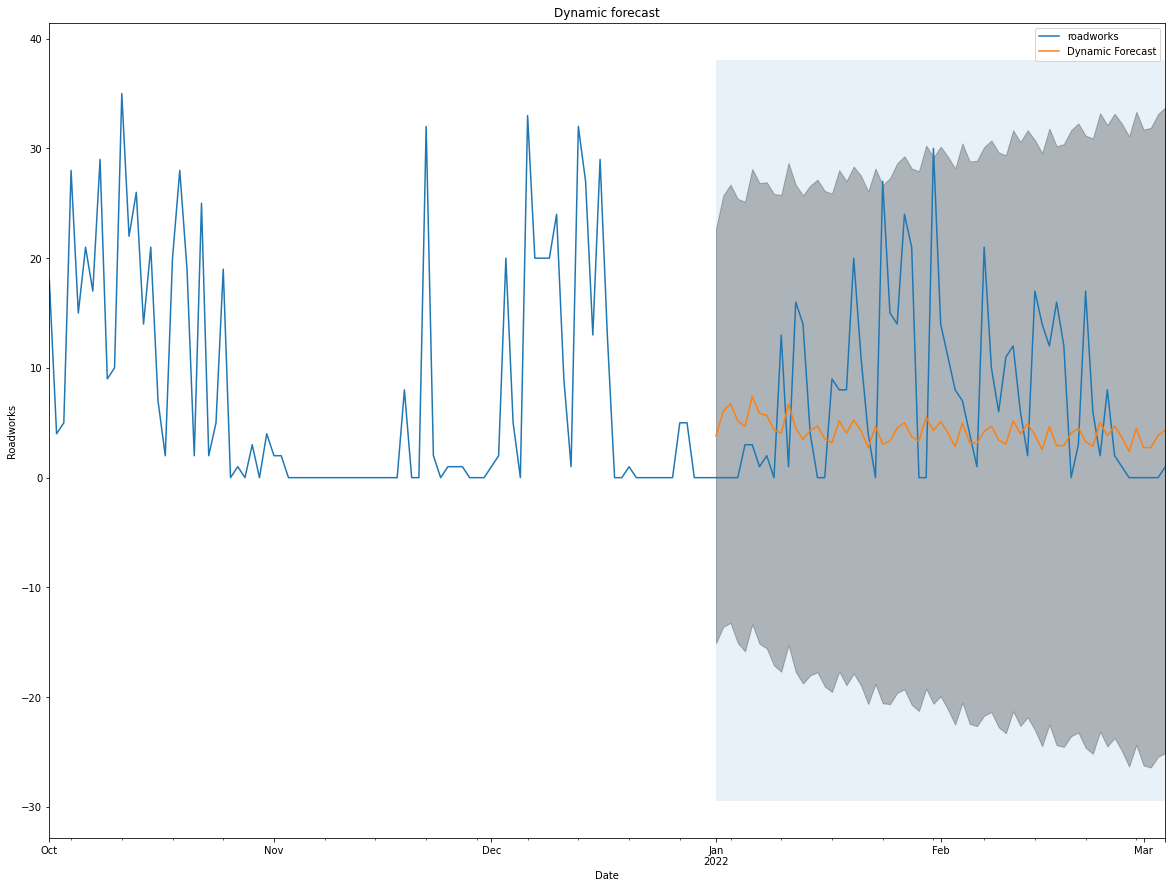

In [37]:
# Show reference data
ax = udf[['roadworks']]['2021-10':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
# Show predicted values
ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
# Show confidence of the model's prediction
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(pred_date), udf[['roadworks']].index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Roadworks')
ax.set_title('Dynamic forecast')

plt.legend()
plt.show()

OLD GRAPH:

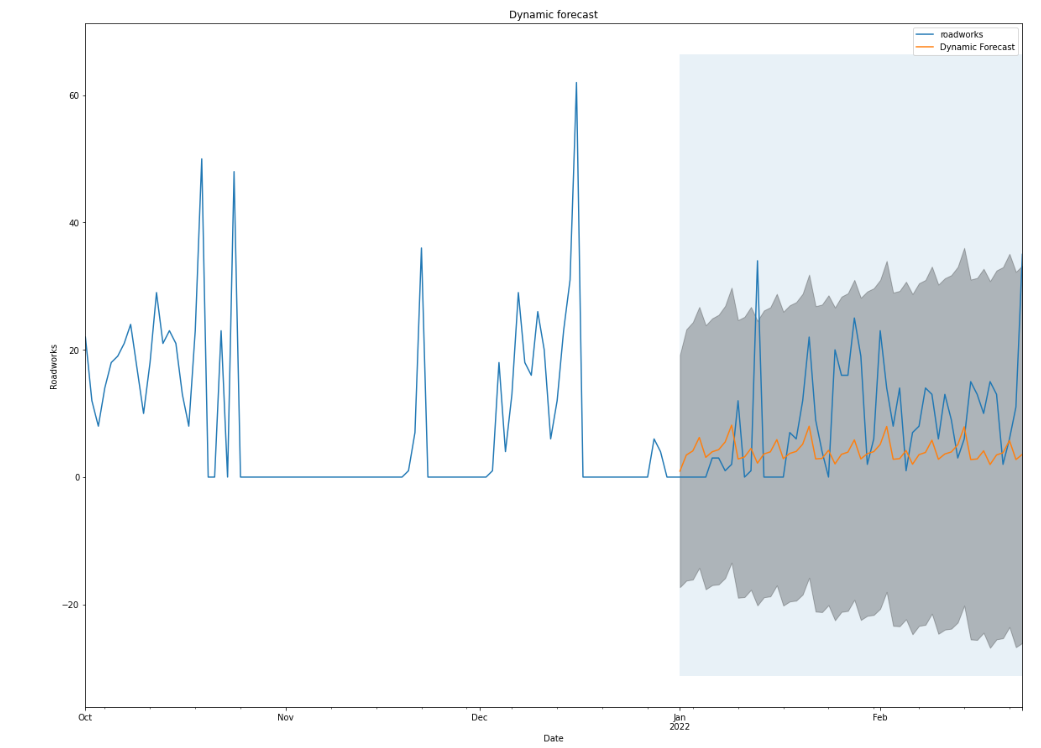

# Evaluation
We've compared the new data without the outliers and non working hours. This caused us to have less datapoints, which makes the prediction less secure. The less datapoints are caused by not using loaddatetime_utc (instead of this we've used roadworks_start, so less hours) and by not using non working hours (less spikes).

This was good for the data but it didn't help improve our model. The prediction is still a bit insecure and doesn't seem to be too usefull. Which means we suggest JUGO to not dive deeper into predicting the future, unless they have more data.

Other than that we decided to leave the weekends in the prediction, if the prediction would be accurate. We would try and make it more accurate/secure by removing the weekends and predicting it that way. But since the prediction is very insecure and doesn't give us much insight, we've decided to leave this unless we find a dataset with more datapoints.